In [26]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')

In [27]:
import warnings
warnings.filterwarnings('ignore')

--- 
<h1 align="center"> Regression Model Fitting and Techniques </h1><br>
***

The overall goal of this section is to try various techniques to fit a model for mortality rate using food consumption data.  First, we will find a null model, representing the 'average' input and representing a baseline estimation that we will then improve upon. Then we will fit a multilinear regression to all of the predictors (all livestock and all crop predictors), and find a cross-validated $R^2$ for this naive model. Next, we will try more advanced techniques such as Lasso, Ridge, Step-wise, and Regression Trees to improve this model. 

To summarize, our null model achieved a cross-validated $R^2$ score of 0 for all three diseases. Our naive model achieved a cross-validated score of $ $ for diabetes, $ $ for cancer, and $ $ for cardiovascular diseases.
***

In [28]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
import math
from sklearn.cross_validation import cross_val_score, LeaveOneOut
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm

%matplotlib inline

In [29]:
# Read in initial dataframe
x_df = pd.read_csv('predictors_filled_156.csv', index_col=0)

# read in disease rates
diabetes_df = pd.read_csv('diabetes_156.csv',index_col = 0)
cardio_df = pd.read_csv('cardio_156.csv',index_col = 0)
cancer_df= pd.read_csv('cancer_156.csv',index_col = 0)

## Null Model

Before fitting the linear regression, we will find a simple null model for global food consumption data. To calculate the null model, we found the average of each predictor column in the Dataframe. This gives us a 'global average' of consumption of each predictor. We can then use the null model to establish a baseline $R^2$ that we will then improve upon using our linear regression models.

### Null Model testing:

As expected, testing the null model on various training set give us a cross-validated $R^2$ of approximately zero for all three diseases. 

#### Cancer: 
The null model for cancer will always predict the mean cancer mortality rate. Testing on cancer, we get an $R^2$ of 3.33 E -16, which is ~ 0:

In [30]:
# Null Model Cancer
null_model = LinReg()
null_model.fit(x_df, [np.mean(cancer_df['Cancer Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
# Test Cancer.
print "r^2:", null_model.score(x_df, cancer_df)

r^2: 0.0


#### Diabetes
Testing on diabetes, we also get an $R^2$ of 0.

In [32]:
# Fit Diabetes Null Model
null_model = LinReg()
null_model.fit(x_df, [np.mean(diabetes_df['Diabetes Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# Test Diabetes.
print "r^2:", null_model.score(x_df, diabetes_df)

r^2: 0.0


#### Test Cardiovascular Diseases

Similarly, on cardiovascular diseases, we get an $R^2$ of 0. This is expected since we are only predicting the mean mortality rate for each disease, and gives us a baseline $R^2$ to improve upon in our later models. 

In [34]:
# Test cardiovascular diseases
null_model = LinReg()
null_model.fit(x_df, [np.mean(cardio_df['Cardio Mortality Rate'])]*x_df.shape[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
# Test cardiovascular diseases.
print "r^2:", null_model.score(x_df, cardio_df)

r^2: 0.0


# Simple LinReg

We'll start by fitting a simple multi-linear regression to all of the food consumption inputs for each of the diseases. Although each of the predictors individually did not have very high $R^2$ values (as seen in the individual scatter plots in Data Exploration), we hope that combining all the predictors will give us more insight into disease mortality rates - just as a single type of food consumed doesn't tell us very much about a peron in general's diet. 

To summarize, our simple linear regression

## Cancer LinReg

First, for cancer, our simple linear regression has an initial $R^2$ on the training set of .85, and a cross-validated $R^2$ of -6.8 for $k = 7$ folds. We chose a higher number of folds because our model requires data for a large majority of the set - for instance, it would not be possible to give a good estimate of a country in Eastern Africa if our k-fold split excluded most or all of the countries in eastern Africa. While the cross-validated $r^2$ is low, we hope to improve it in later models. The much higher score on the training set (.85), however, indicates that we may still be able to use the model to understand more about the relationship between diet and disease mortality rate.

In [36]:
linreg = LinReg()
linreg.fit(x_df, cancer_df)
print "Training r^2:",linreg.score(x_df, cancer_df)

Training r^2: 0.84195244487


In [37]:
# Cross validated R-squared score
np.mean(cross_val_score(LinReg(), x_df,cancer_df, cv = KFold(156, 7), scoring = "r2"))

-6.8732307764266016

## Diabetes LinReg
For diabetes, our regression has training r^2 of .799 and a cross-validated $R^2$ (7 folds) of -5.267. Just as we saw with cancer, the low cross-validated $r^2$ is something we hope to improve in the later models.

In [38]:
linreg = LinReg()
linreg.fit(x_df, diabetes_df)
print "Training R^2", linreg.score(x_df, diabetes_df)

# Cross-validated R^2 score for diabetes
print "CV R^2 score:",np.mean(cross_val_score(LinReg(), x_df,diabetes_df, cv = KFold(156, 7), scoring = "r2"))

Training R^2 0.798957468094
CV R^2 score: -5.26741799047


## Cardiovascular Diseases LinReg
For diabetes, our regression has an initial $R^2$ on the training set of .856, and a cross-validated $R^2$ of -2.99, which we hope to improve in later models.

In [39]:
linreg = LinReg()
linreg.fit(x_df, cardio_df)
print "Training R^2", linreg.score(x_df, cardio_df)
print "Cross-validated R^2", np.mean(cross_val_score(LinReg(), x_df,cardio_df, cv = KFold(156, 7), scoring = "r2"))

Training R^2 0.850753213995
Cross-validated R^2 -2.99064635398


--- 
# Advanced Models 
***

In this section, we will use various other regression techniques and variable selection techniques to attempt to improve upon our naive model. Variable selection is a type of technique that tries to reduce the number of predictors to obtain a less overfitted model. Since we start with 104 predictors, using variable selection would be a valuable technique because we gain additional insight into which predictors are more important. In particular, we will try 

1. Lasso
2. Ridge
3. Regression Tree

For reference, our naive model gives us the following training and cross-validated $R^2$ values with $k = 5$: 

||Cardio | Diabetes | Cancer
|--- | --- | --- | ---|
|R^2 (Training)| .856 | .834 | .856|
|R^2 (CV, 7-fold)| -2.99 |-5.267| -6.873 |

## Lasso

The naive model brought up in the previous section has one major flaw: by including all of the predictors, it is very likely to be overfitted to the initial dataset. As such, we would like to reduce that overfitting by using variable selection techniques such as Lasso to reduce the number of predictors our model includes. Since Lasso is a variable selection technique, we can also see which predictors are more likely to be important and more correlated with disease rates, since insignifcant predictors would likely have a zero coefficient after running lasso. 
Using the Lasso package in sklearn, we obtain the following cross-validated $R^2$:

| |Cardio   |  Diabetes | Cancer  |
|-----|---|---|---|
|$r^2$ (Lasso) |  .466 |  .351 |   .200|


Below is a function we used to calculate the cross-validated r^2 for lasso over a number of folds for a certain parameter value.

In [40]:
def lasso_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = Lasso(alpha = param_val, normalize=True)
        reg.fit(x_train_cv, y_train_cv)
        coefficients = reg.coef_
        #print len([i for i, item in enumerate(coefficients) if abs(item) >0])
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cancer

On the cancer dataset, we ran lasso on different values of alpha yields a top cross-validated $r^2$ score of .200, for alpha = .5. Below is a table of values for 7-fold CV, the number of folds that yielded the best result. This suggests the best lasso model on the cancer dataset occurs when we tune alpha to .5. 

|alpha = | .01 | .1 | .4 |.5 | .6 | 1 | 5 |
|:---: | :---: | :---: | :---:| :---: |:---: | :---: | :---:|
|$r^2$ (Cross-validated)| -3.312 | -0.138 | 0.199| 0.200 | 0.189 | 0.097 | -0.039 |

Best result: 7
[-3.0716214052909834, -0.13789168408078353, 0.19870077023170749, 0.19999859424352939, 0.18912224676322445, 0.096879062313412465, -0.039280567460263462]


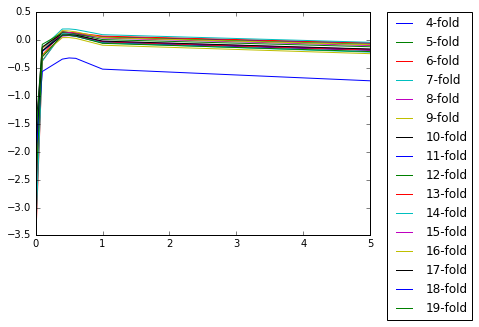

In [41]:
alphas = [.01, .1, .4, .5, .6, 1, 5]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, cancer_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds - minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Cardiovascular Diseases
We also ran Lasso on the cardiovascular dataset for different values of alpha, yielding a top cross-validated $r^2$ score of .46, for alpha = .9. Below is a table of values for 6-fold CV, the number of folds that yielded the best result.

|alpha = |.1 | .5 | .8 | .9 |1 | 2 |5 | 10 |
|:---: | :---: | :---: | :---:| :---: |:---: |
|R^2 (Cross-validated)| 0.069 | 0.450 | 0.466 | 0.466|  0.465 | -0.052 | 0.465 | -0.052 |

Best result: 7
[0.068919368912754367, 0.44995652077827769, 0.46591704040853449, 0.46619631137525996, 0.4653178174557116, 0.4013590656790495, -0.028856706072512877, -0.038971246907405784]


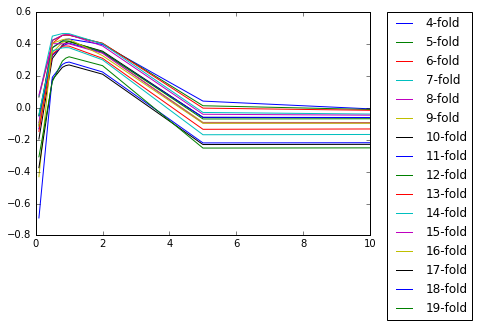

In [42]:
alphas = [.1, .5,.8, .9, 1, 2,5, 10]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4
for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, cardio_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(4, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Diabetes 
Running Lasso on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of .351, for alpha = .1. Below is a table of values for 6-fold CV, the number of folds that yielded the best result.

|alpha = |.01 | .05 | .1 | .5 |1 | 10 |
|:---: | :---: | :---: | :---:| :---: |:---: |
|R^2 (Cross-validated)| -0.856 | 0.206 | 0.351 | 0.168|  -0.013 | -0.052 |

Best result: 6
[-0.80894256078092708, 0.20741629722856447, 0.3562249279596072, 0.16818441216842792, -0.013371647827624419, -0.052239676530777213]


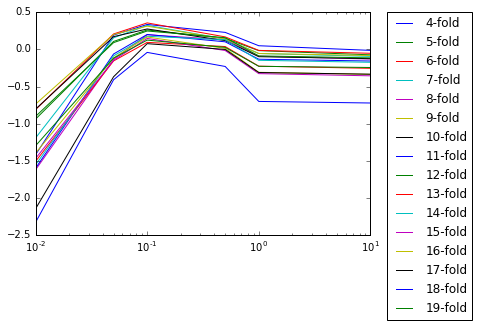

In [43]:
alphas = [.01, .05, .1, .5, 1, 10]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(lasso_k_fold_r_squared(x_df, diabetes_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

## Ridge 

Again, in this section we'd like to try to use Ridge regression to improve the cross-validated $r^2$ for our model and reduce overfitting of the model. While lasso performs variable selection by replacing some of the coefficients with zero (effectively reducing the number of coefficients), ridge regression will simply lower the magnitude of the coefficients. Models that we obtain through ridge regression deemphasize unimportant predictors rather than completely removing them, since less-important predictors will have their coefficients shrunk by more.

Below is a function we used to calculate the cross-validated r^2 for ridge regression over a number of folds for a certain parameter value.

To summarize, the best $r^2$ values obtained by running ridge regression on the three datasets are:


| |Cardio   |  Diabetes | Cancer  |
|-----|---|---|---|
|$r^2$ (Ridge) |  .424 |  .323 |   .168|

Comparing to lasso, ridge did not perform as well as lasso on any of the three datasets. Both lasso and ridge performed much better than the naive model on all three datasets. 

In [44]:
from sklearn.linear_model import Ridge
def ridge_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = Ridge(alpha = param_val, normalize=True)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cardiovascular Diseases
Running Ridge regression on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of 0.454, for alpha = 1.5

RIDGE
Best result: 6
[-1.6579278682390104, -0.68650731090100037, 0.12094949640669521, 0.4444723532385591, 0.44846087765514558, 0.45126249626035114, 0.45427748365878418, 0.45487440330471546, 0.45164995579165707, 0.38131352338687124, 0.28717889463927132, 0.27312107909030758, 0.041254979076858732]


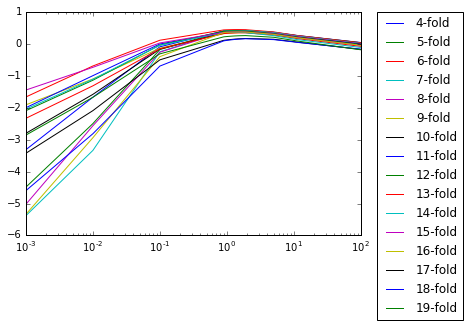

In [45]:
print "RIDGE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.001, .01, .1, .9,1,1.1,1.3,1.5,1.9,5, 10, 11, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
for folds in range(4, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, cardio_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-4]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-4], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

### Diabetes

Running Lasso on different values of alpha from .001 to 1000 yields a top cross-validated $r^2$ score of 0.325, for alpha = 3

Best result: 4
[-8.1030602459262209, -3.1417076657284051, -0.24255175076154106, 0.31322748421245195, 0.3188210611824896, 0.32032740889199141, 0.29497181620056534, 0.24282986991487349, 0.053613621663044175, -0.0050218403281335477]


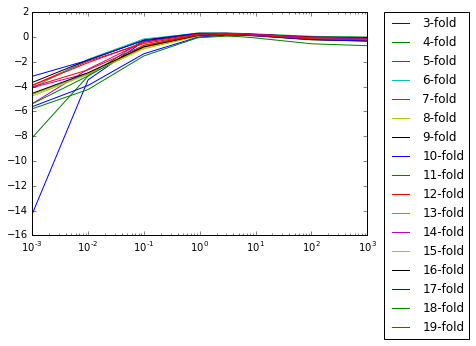

In [46]:
alphas = [.001, .01, .1, .9, 1, 3, 5, 10, 100, 1000]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, diabetes_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

### Cancer

Running Ridge on different values of alpha from .001 to 100 yields a top cross-validated $r^2$ score of 0.222, for alpha = .5

RIDGE
Best result: 7
[-5.5162309411504378, -3.4016991284618321, -0.64007127152737309, 0.13520671920987423, 0.21857433736908763, 0.22224407448512729, 0.22075182197007409, 0.19589339307788209, 0.030355994290426697, -0.030747205224301251]


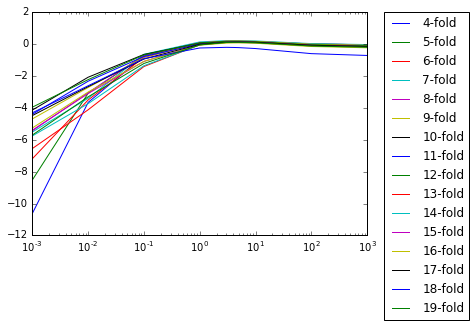

In [47]:
print "RIDGE"
#for folds in range(3, 32):
    #if folds == 27 or folds == 28:
        #continue
alphas = [.001, .01, .1, 1, 3, 4, 5, 10, 100, 1000]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 4

for folds in range(minfolds, 20):
    temp = []
    for alpha in alphas:
        temp.append(ridge_k_fold_r_squared(x_df, cancer_df, folds, alpha))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(alphas, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale("log", nonposx='clip')
plt.show()

---
## Regression Trees
---

In this section, we'll try regression trees to see if they improve our model. Regression trees use a tree-like structure to predict, so if we're able to prune the tree and lower the maximum depth we could have a similar effect to reducing the number of predictors.

Below, we have a function that we'll use to find the $r^2$ value for a given number of folds and certain hyperparameter (in this case, max_depth).

In [48]:

def rtree_k_fold_r_squared(x_train, y_train, num_folds, param_val):
    n_train = x_train.shape[0]
    n = int(np.round(n_train * 1. / num_folds)) # points per fold

    # Iterate over folds
    cv_r_squared = 0
    
    for fold in range(1, num_folds + 1):
        # Take k-1 folds for training 
        x_first_half = x_train.iloc[:n * (fold - 1), :]
        x_second_half = x_train.iloc[n * fold + 1:, :]
        x_train_cv = np.concatenate((x_first_half, x_second_half), axis=0)
        
        y_first_half = y_train.iloc[:n * (fold - 1)]
        y_second_half = y_train.iloc[n * fold + 1:]
        y_train_cv = np.concatenate((y_first_half, y_second_half), axis=0)
        
        # Take the middle fold for testing
        x_test_cv = x_train.iloc[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train.iloc[1 + n * (fold - 1):n * fold]

        # Fit Decision Tree model with parameter value on CV train set, and evaluate CV test performance
        reg = DecisionTreeRegressor(max_depth=param_val)
        reg.fit(x_train_cv, y_train_cv)
        r_squared = reg.score(x_test_cv, y_test_cv)
    
        # Cummulative R^2 value across folds
        cv_r_squared += r_squared

    # Return average R^2 value across folds
    return cv_r_squared * 1.0 / num_folds

### Cardiovascular Diseases

For cardiovascular diseases, we see the best $r^2 = 0.424$ for max_depth = 2. 

Best result: 5
[0.42433540322609253, 0.31037836342049879, 0.19247221158882119, 0.19508758994525482, 0.23664627315056372, 0.12205190228669119, 0.044465769172116754, 0.092096221738134657, 0.17122101160181497]


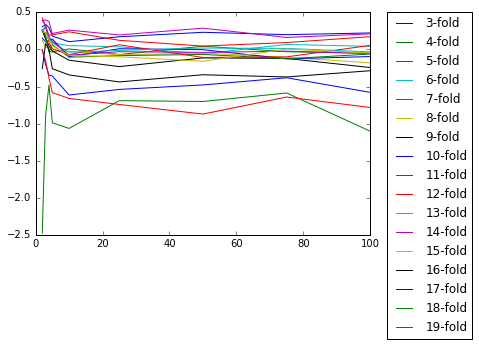

In [49]:
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,cardio_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Diabetes

For diabetes, we see the best $r^2$ of $0.227$ for a max-depth of 4. This is slightly worse than the results from lasso and ridge, which were able to achieve .351 and .321 respectively.

Best result: 9
[0.19868864967625982, 0.15787417539977178, 0.22398095011625388, 0.075200583002116073, -0.17754974933047299, -0.28264005855583457, -0.24547209105262968, -0.22943587916161323, -0.19091864162960481]


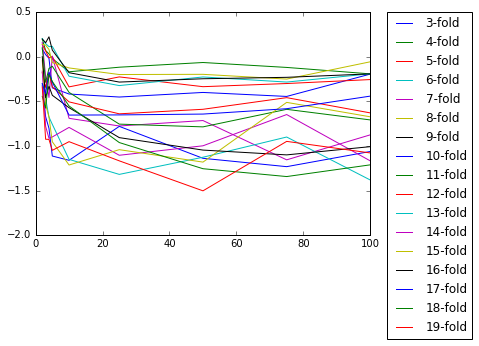

In [50]:
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = 0
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,diabetes_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Cancer

All of the $r^2$ for decision trees on cancer were negative, indicating that these actually perform worse than the null model and as such are not useful models to examine.

Best result: -1
[-0.52557329404481157, -0.59778764146250929, -0.81106181842626102, -0.9318008821422411, -0.89793449257471158, -0.96853031902189513, -1.1776998684521793, -1.1924420674673257, -1.0519215168759595]


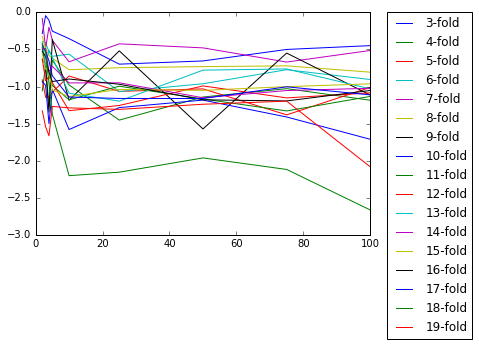

In [51]:
depths = [2, 3, 4, 5, 10, 25, 50, 75, 100]
cv_r2 = []
maxr2 = 0
bestfolds = -1
minfolds = 3

for folds in range(minfolds, 20):
    temp = []
    for depth in depths:
        temp.append(rtree_k_fold_r_squared(x_df,cancer_df,folds, depth))
    localmax = max(temp)
    if localmax > maxr2:
        maxr2 = localmax
        bestfolds = folds
    cv_r2.append(temp)
print 'Best result:', bestfolds
print cv_r2[bestfolds-minfolds]
    
for i in range(minfolds, 20):
    plt.plot(depths, cv_r2[i-minfolds], label = str(i) + '-fold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xscale("log", nonposx='clip')
plt.show()

# Advanced Models: Summary

In conclusion, we found lasso to be the best feature selector for all three datasets. For cardiovascular diseases, lasso (alpha = .9) yielded a cross-validated $r^2$ of .466. For diabetes, lasso (alpha = .1) yielded a cross-validated $r^2$ of .351. For cancer, lasso (alpha = .5) yielded a cross-vlidated $r^2$ of .200. In geenral, the cardiovascular disease dataset obtained higher $r^2$ for each model, suggesting that the link between diet and cardiovascular disease mortality rates might be stronger than the link between diet and disease mortality rates of the other two diseases. Cancer had the weakest $r^2$, with a maximal cross-validated $r^2$ of only .2. This suggests that the link between cancer and diet is just not very strong, and there are lot of other factors (such as environment, exposure to certain carcinogens, family history, medical treatment quality) that may have a stronger link to cancer mortality rates.

| |Cardio   |  Diabetes | Cancer  |
|-----|---|---|---|
|$r^2$ (CV, Naive)| -2.99 |-5.267| -6.873 |
|$r^2$ (CV, Lasso) |  .466 |  .351 |   .200|
|$r^2$ (CV, Ridge) |  .424 |  .323 |   .168|
|$r^2$ (Cv, Regr. Trees) |  .424 |  .227 |   -1|

Below, we'll fit the three best predictors to our entire training dataset using the Lasso regressor from sklearn.linear_model, and we see that they perform pretty well on the initial training dataset as well: 


In [52]:
cardio_reg = Lasso(alpha = .9)
cardio_reg.fit(x_df, cardio_df)
print "training r^2 for cardio:",cardio_reg.score(x_df, cardio_df)

training r^2 for cardio: 0.8069010383


In [53]:
diabetes_reg = Lasso(alpha = .1)
diabetes_reg.fit(x_df, diabetes_df)
print "training r^2 for diabetes:",diabetes_reg.score(x_df, diabetes_df)

training r^2 for diabetes: 0.759254268841


In [54]:
cancer_reg = Lasso(alpha = .5)
cancer_reg.fit(x_df, cancer_df)
print "training r^2 for cancer:",cancer_reg.score(x_df, cancer_df)

training r^2 for cancer: 0.728711616866


The fact that these training $r^2$ still perform pretty well indicate that these models strike a good balance between being not too overfitted and still describing the relationships in the original dataset, so we can analyze these models to get a better understanding of the relationship and correlations between the predictors (dietary consumption of various foods) and disease mortality rates, as we will do in the next section. 